In [200]:
import pandas as pd

df = pd.read_excel(r'C:\Users\ali.karimi\Documents\JupyterProjects\RFM\2010-2011.xlsx')
print (df.shape)
display(df.head())


(541910, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [201]:
print(df.shape)
df.isnull().sum()

df_clean=df.dropna(subset=['Customer ID'])
df_clean['Customer ID']=df_clean['Customer ID'].astype(int)

df_clean.isnull().sum()
df_clean.dtypes
df=df_clean.copy()

(541910, 8)


C:\Users\ali.karimi\AppData\Local\Temp\ipykernel_13940\3689083086.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [202]:

df['TotalPrice'] = df['Quantity'] * df['Price']

df = df[~df['Invoice'].astype(str).str.startswith('C')]

import datetime as dt

# تاریخ مرجع برای محاسبه Recency
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# گروه‌بندی برای RFM
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# تغییر نام ستون‌ها
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm = rfm.reset_index()
rfm.head()



,Customer ID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [203]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

rfm_scaled['Customer ID']=rfm['Customer ID']
for i in ['Recency', 'Frequency', 'Monetary']:
    rfm_scaled[i]=scaler.fit_transform(rfm[[i]])

X=rfm_scaled[['Recency', 'Frequency', 'Monetary']]
X.head()

,Recency,Frequency,Monetary
0,2.334858,-0.424675,8.359634
1,-0.905199,0.354080,0.251046
2,-0.175186,-0.035297,-0.028547
3,-0.735196,-0.424675,-0.032963
4,2.174855,-0.424675,-0.191316


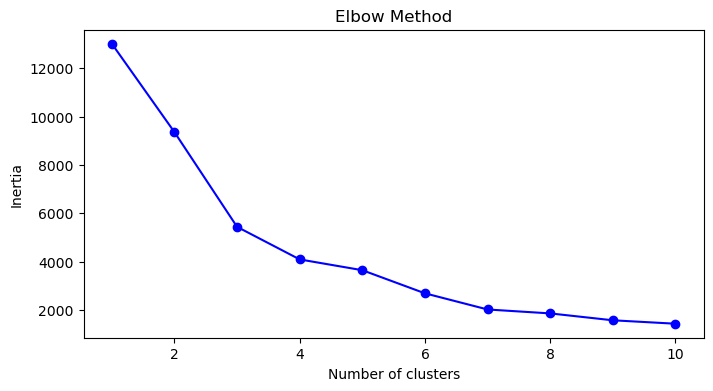

In [204]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns


inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)  # یا هر دیتایی که scale شده
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [205]:
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    print(f'k={k} -> silhouette score: {score:.4f}')

k=2 -> silhouette score: 0.8959
k=3 -> silhouette score: 0.5943
k=4 -> silhouette score: 0.6165
k=5 -> silhouette score: 0.6167
k=6 -> silhouette score: 0.5983
k=7 -> silhouette score: 0.5193
k=8 -> silhouette score: 0.4768
k=9 -> silhouette score: 0.4776
k=10 -> silhouette score: 0.4261


In [206]:
#Based on the Elbow method, Silhouette score, and the overall characteristics of the clusters, k = 4 is the optimal choice for clustering.

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
labels = kmeans.fit_predict(X)

rfm['Cluster'] = labels
print("Silhouette on rfm_scaled:", silhouette_score(X, labels).round(4))


Silhouette on rfm_scaled: 0.6165


In [207]:
cluster_summary = rfm.groupby('Cluster').agg(
    Customers = ('Cluster', 'count'),
    Recency_mean = ('Recency','mean'),
    Frequency_mean = ('Frequency','mean'),
    Monetary_mean = ('Monetary','mean'),
    Monetary_sum = ('Monetary','sum')
).sort_index()

cluster_summary['Pct_Customers'] = (cluster_summary['Customers'] / cluster_summary['Customers'].sum() * 100).round(2)
cluster_summary = cluster_summary[['Customers','Pct_Customers','Recency_mean','Frequency_mean','Monetary_mean','Monetary_sum']]
cluster_summary

for col in ['Customers','Recency_mean','Frequency_mean','Monetary_mean','Monetary_sum']:
    cluster_summary[col] = cluster_summary[col].round(0).astype(int)

cluster_summary


,Customers,Pct_Customers,Recency_mean,Frequency_mean,Monetary_mean,Monetary_sum
Cluster,,,,,,
0,3059,70.5,44,4,1358,4152683
1,1063,24.5,248,2,480,510690
2,13,0.3,7,83,127338,1655398
3,204,4.7,16,22,12709,2592654


In [229]:
# generate_rfm_html_from_existing.py
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
HTML_OUT = os.path.join(OUT_DIR, "rfm_report.html")

# Assumes `rfm` and `X` already exist in the environment (as in your notebook)
# rfm: DataFrame with columns ['Customer ID','Recency','Frequency','Monetary','Cluster']
# X: scaled features used for clustering with same number of rows as rfm

# --------- Cluster summary (format as in your pipeline) ----------
cluster_summary = rfm.groupby('Cluster').agg(
    Customers=('Cluster','count'),
    Recency_mean=('Recency','mean'),
    Frequency_mean=('Frequency','mean'),
    Monetary_mean=('Monetary','mean'),
    Monetary_sum=('Monetary','sum')
).sort_index()

cluster_summary['Percent_Customers'] = (cluster_summary['Customers'] / cluster_summary['Customers'].sum() * 100).round(1)
cluster_summary = cluster_summary[['Customers','Percent_Customers','Recency_mean','Frequency_mean','Monetary_mean','Monetary_sum']]

# round display numbers (except Pct_Customers)
disp = cluster_summary.copy()
for col in ['Customers','Recency_mean','Frequency_mean','Monetary_mean','Monetary_sum']:
    disp[col] = disp[col].round(0).astype(int)

table_html = disp.reset_index().to_html(index=False, classes='table')

# --------- Boxplots (Plotly) ----------
# --------- nicer consistent-colored plots (replace original box/3D/PCA blocks) ----------
import plotly.express as px

# create a string cluster column for safer mapping
# ---------- consistent ordering + color map (replace previous palette / clusters_sorted block) ----------
# ensure Cluster_str exists
rfm['Cluster_str'] = rfm['Cluster'].astype(str)

# desired left-to-right order for boxes
# ترتیب دلخواه از چپ به راست
order_str = [str(c) for c in sorted(rfm['Cluster'].unique())]  # -> ['0','1','2','3']

# اطمینان از اینکه کلیدهای رنگ رشته هستند و نقشه رنگ هم رشته-محور باشه
palette = ["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692"]
color_discrete_map = { order_str[i]: palette[i % len(palette)] for i in range(len(order_str)) }

# تبدیل به categorical با ترتیب ثابت — این مهم‌ترین خطه
rfm['Cluster_str'] = pd.Categorical(rfm['Cluster'].astype(str), categories=order_str, ordered=True)

# --- 3D scatter (با category_orders و نقشه رنگِ رشته‌ای) ---
fig3d = px.scatter_3d(
    rfm,
    x='Recency', y='Frequency', z='Monetary',
    color='Cluster_str',
    category_orders={'Cluster_str': order_str},
    color_discrete_map=color_discrete_map,
    hover_data=['Customer ID','Recency','Frequency','Monetary'],
    title='RFM 3D Scatter',
    template='plotly_white'
)
fig3d.update_traces(marker=dict(size=5, opacity=0.85, line=dict(width=0)))
fig3d.update_layout(width=1000, height=800)
fig3d_html = pio.to_html(fig3d, full_html=False, include_plotlyjs=False)

# --- PCA 2D (با همان تنظیمات سفارش و رنگ) ---
fig_pca = px.scatter(
    pca_df, x='PC1', y='PC2', color='Cluster_str',
    category_orders={'Cluster_str': order_str},
    color_discrete_map=color_discrete_map,
    hover_data=['Customer ID'],
    title='PCA (2D) of RFM',
    template='plotly_white'
)
fig_pca.update_traces(marker=dict(size=7, opacity=0.85, line=dict(width=0)))
fig_pca.update_layout(width=900, height=600, legend_title='Cluster')
fig_pca_html = pio.to_html(fig_pca, full_html=False, include_plotlyjs=False)



# --------- Heatmap of cluster means (colors scaled; hover shows actual means) ----------
means_orig = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(2)
mm = MinMaxScaler()
means_scaled = pd.DataFrame(mm.fit_transform(means_orig), index=means_orig.index, columns=means_orig.columns)
hover = []
for idx in means_orig.index:
    row = []
    for col in means_orig.columns:
        row.append(f"{col}: {means_orig.loc[idx,col]:,}")
    hover.append(row)

heat = go.Figure(data=go.Heatmap(
    z=means_scaled.values,
    x=means_scaled.columns,
    y=[f"Cluster {c}" for c in means_scaled.index],
    text=hover,
    hoverinfo='text',
    colorscale='Viridis'
))
heat.update_layout(title='Cluster means (colors scaled; hover shows actual values)', width=800, height=320)
heat_html = pio.to_html(heat, full_html=False, include_plotlyjs=False)

# --------- Top customers table ----------
top_customers = rfm.sort_values('Monetary', ascending=False).head(10)[['Customer ID','Recency','Frequency','Monetary','Cluster']]
top_customers_html = top_customers.to_html(index=False, classes='table', float_format='{:,.0f}'.format)

# --------- Compose HTML (single file) ----------
html = f"""
<html><head><meta charset='utf-8'><title>RFM Report</title>
<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
<style>
body{{font-family:Arial,Helvetica,sans-serif;margin:20px 30px;background:#fff;color:#111}}
.container{{max-width:1200px;margin:auto}}
.card{{background:#fafafa;padding:16px;border-radius:6px;margin-bottom:18px;box-shadow:0 1px 3px rgba(0,0,0,0.05)}}
h1{{text-align:center}}
.table{{border-collapse:collapse;width:100%;margin-top:8px}}
.table th,.table td{{border:1px solid #eee;padding:8px;text-align:center}}
.small{{color:#666;font-size:0.9rem}}
</style></head><body><div class='container'>
<h1>RFM Segmentation Report</h1>
<p class='small'>Using existing clustering in <code>rfm['Cluster']</code>.</p>

<div class='card'><h2>Cluster summary</h2>{table_html}</div>

<div class='card'><h2>Boxplots (Recency, Frequency, Monetary)</h2>{box_r_html}<br/>{box_f_html}<br/>{box_m_html}</div>

<div class='card'><h2>3D Scatter (Recency, Frequency, Monetary)</h2>{fig3d_html}</div>

<div class='card'><h2>PCA (2D)</h2>{fig_pca_html}</div>

<div class='card'><h2>Heatmap (cluster means)</h2>{heat_html}</div>

<div class='card'><h2>Top 10 customers by Monetary</h2>{top_customers_html}</div>

<div class='small'>Report generated from your rfm DataFrame. Outputs saved in: {OUT_DIR}</div>
</div></body></html>
"""

with open(HTML_OUT, "w", encoding="utf-8") as f:
    f.write(html)

print("Saved HTML to:", HTML_OUT)


Saved HTML to: outputs\rfm_report.html
